# Cubed sphere grid explanation with Weimer potential

Create a figure explaining the cubed sphere grid object (Figure 1 in paper).

We will use the Weimer (2005) model to get a potential $\Phi$ for the northern hemisphere. Using the differentiation matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ from the cubed sphere grid object, we can differentiate this scalar field and get the electric field through the relation $\mathbf{E} = -\nabla\Phi$. When ignoring inductive effects this equation relates the electric fieldand the electrostatic potential. We can also get the divergence of the electric field $\mathbf{E}$ by using the $\mathbb D_{\nabla\cdot}$ matrix from the cubed sphere grid object. When applied to a vector field, $\mathbb D_{\nabla\cdot}$ produces the divergence of the vector field. 

Below we:
 1. Set up the cubed sphere projection and grid
 2. Read a Weimer model output file and define electrostatic potential on grid
 3. Get east, north electric field from the potential
 4. Get the divergence of the electric field and multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
# temporary to see how run time changes for different parameters
from datetime import datetime
starttime = datetime.now()

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import lompe

Re = 6371.2e3    # Earth radius
eps0 = 8.854e-12 # Electric permittivity of free space 
stencil_size = 1 # Size of the stencil used for numerical differentiation

The cube face is centered at the north pole (0$^{\circ}$ longtude and 90$^{\circ}$ latitude) and oriented along the meridian (orientation set to zero implies axis in the east-west direction). the projection is used to set up an equal area grid in cubed sphere coordinates. Here, the grid covers a 20 000 km $\times$ 20 000 km area.

In [3]:
Lres, Wres = 50e3, 50e3 # m
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, Lres, Wres, R = Re+110e3) # set to ionospheric altitude
SKIP = 20 # how many grid points to skip when smoothing 

Next, we read a Weimer (2005) model output file and interpolate the potential $\Phi$ on the grid:

In [5]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep = ' ', skipinitialspace = True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt .values.reshape((181, 61)) * 15  # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'cubic').reshape(grid.shape)

The grid object contains the matrices that produces derivative in eastward and northward direction of a scalar field defined on the grid: $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$. We use the matrices to differentiate $\Phi$ to get electric field components:
\begin{equation*}
    \mathbf{E}_{\mathbf{e}} = -\mathbb D_{\mathbf{e}\cdot\nabla}\cdot\Phi
\end{equation*}
\begin{equation*}
    \mathbf{E}_{\mathbf{n}} = -\mathbb D_{\mathbf{n}\cdot\nabla}\cdot\Phi
\end{equation*}
    
The stencil_size scales the interval for the final difference calculation of the derivatives. A larger stencil size will usually yield more accurate derivatives, but is more sensitive to noise. We have stencil_size = 1, and the derivatives are calculated with a 3-point stencil.
    
    TODO: WHY RETURN SPARSE?
We choose to make the differation matrices sparse (if not they would be vary large?).

In [6]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)

We can also calculate the divergence of the electric field:
\begin{equation*}
    \nabla\cdot\mathbf{E} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathbf{E}_{\mathbf{e}}\\\mathbf{E}_{\mathbf{n}}\end{pmatrix}
\end{equation*}

The grid object contains the matrix that produces the divergence of a vector field (here: $\mathbf{E}$) on the grid: $\mathbb D_{\nabla\cdot}$. $\mathbb D_{\nabla\cdot}$ is a $N\times 2N$ matrix that operates on $\mathbf{E}$ that is a $2N$ column vector.

The divergence of the electric field is related to the charge density, $\rho_c$, through Gauss' law:
\begin{equation*}
    \rho_c = \epsilon_0\nabla\cdot\mathbf{E}
\end{equation*}
where $\epsilon_0$ is the permittivity of free space (constant).

In [7]:
E_tot = np.hstack((E_e.flatten(), E_n.flatten()))

# use cubedsphere divergence matrix to get div(E)
Ddiv = grid.divergence(S = stencil_size, return_sparse = True)
divE = Ddiv.dot(E_tot).reshape(grid.shape)

# convert to charge density - Gauss' law
epsdivE = divE * eps0 

To avoid plotting results of edge effects, we remove the lower latitudes before plotting:

In [8]:
E_e[grid.lat < 61] = np.nan
E_n[grid.lat < 61] = np.nan
epsdivE[grid.lat < 61] = np.nan

Set up figure and plot:

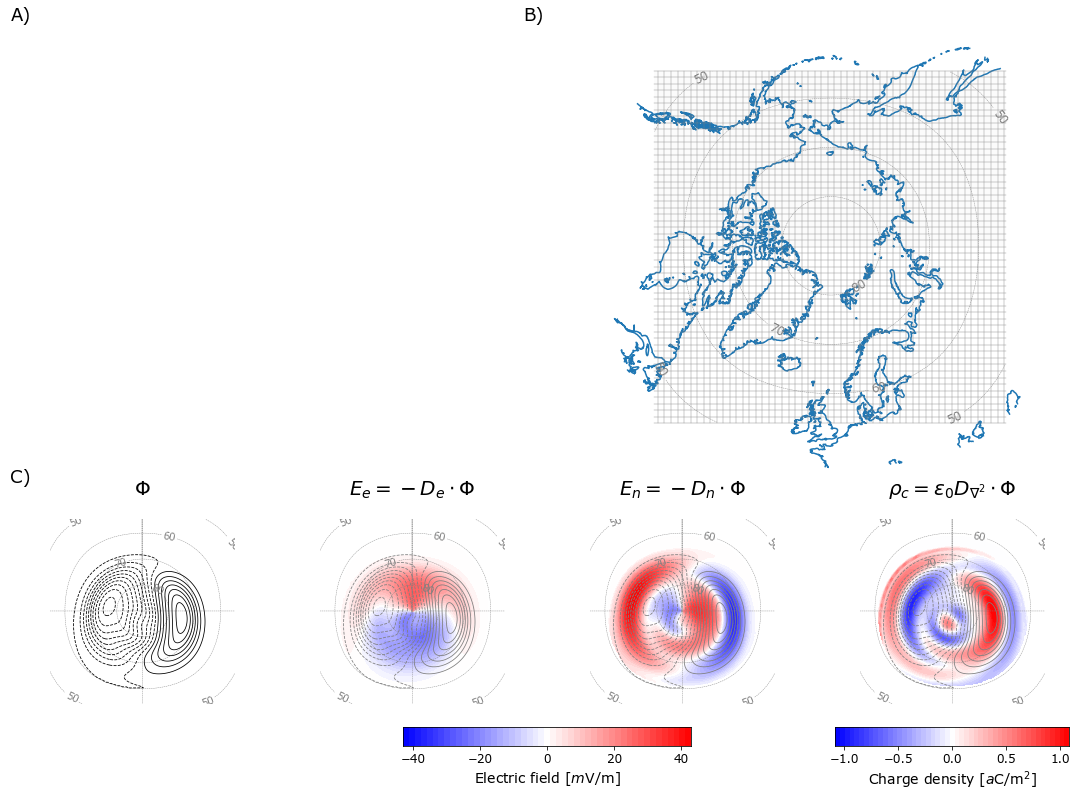

In [12]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (12*1.25, 9*1.25))

axs1, axs2 = {}, {} # initialize dictionaries for axes

# upper row
axs1['onsphere' ] = plt.subplot2grid((25, 40), (2,  0), rowspan = 15, colspan = 20)
axs1['grid'     ] = plt.subplot2grid((25, 40), (1, 20), rowspan = 15, colspan = 20)
axs1['label'    ] = plt.subplot2grid((25, 40), (1,  0))
axs1['label2'   ] = plt.subplot2grid((25, 40), (1, 19))

# lower row
axs2['potential'] = plt.subplot2grid((25, 40), (17,  0), rowspan = 6, colspan = 10)
axs2['E_e'      ] = plt.subplot2grid((25, 40), (17, 10), rowspan = 6, colspan = 10)
axs2['E_n'      ] = plt.subplot2grid((25, 40), (17, 20), rowspan = 6, colspan = 10)
axs2['Ediv'     ] = plt.subplot2grid((25, 40), (17, 30), rowspan = 6, colspan = 10)

axs2['label'    ] = plt.subplot2grid((25, 40), (16, 0))
axs2['label2'   ] = plt.subplot2grid((25, 40), (16, 10))
axs2['label3'   ] = plt.subplot2grid((25, 40), (16, 20))
axs2['label4'   ] = plt.subplot2grid((25, 40), (16, 30))

axs2['cbar'     ] = plt.subplot2grid((40, 60), (38, 22), colspan = 16) # for electric field components
axs2['cbar2'    ] = plt.subplot2grid((40, 60), (38, 46), colspan = 13) # for epsilon0*div(E)

plt.subplots_adjust(hspace = 0, wspace = 0, left = 0, right = 1., bottom = 0.04 ,top = .99)

# labels
axs1['label' ].set_title('A)', fontsize = 18)
axs1['label2'].set_title('B)', fontsize = 18)
axs2['label' ].set_title('C)', fontsize = 18)
#axs2['label2'].set_title('D)', fontsize = 18)
#axs2['label3'].set_title('E)', fontsize = 18)
#axs2['label4'].set_title('F)', fontsize = 18)


###################### upper row of plots #########################

# set up axes for grid visualization
for key in axs1.keys():
    axs1[key].set_axis_off()
    
# A) example of cube face intersecting sphere 
    
# B) cubed sphere grid with coastlines
axs1['grid'].set_aspect('equal')

# add coastlines
for cl in grid.projection.get_projected_coastlines():
    axs1['grid'].plot(cl[0], cl[1], color = 'C0')

# add latitude contours
co = axs1['grid'].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
                                                linewidths = .4, levels = np.r_[-80:81:10])
axs1['grid'].clabel(co, co.levels, inline = True, fontsize = 12)

# plot some of the grid cells
count = -1
for xi, eta in grid.get_grid_boundaries(geocentric = False):
    count += 1
    if count%3 != 0:
        continue
    axs1['grid'].plot(xi, eta, color = 'grey', linewidth = .4)

# shade under grid region 
xs = np.array([grid.xi_mesh[0, 0], grid.xi_mesh[-1, 0], grid.xi_mesh[-1, -1], grid.xi_mesh[0, -1]])
ys = np.array([grid.eta_mesh[0, 0], grid.eta_mesh[-1, 0], grid.eta_mesh[-1, -1], grid.eta_mesh[0, -1]])
axs1['grid'].fill_between(xs, ys, color = 'gray', alpha = .03, edgecolor = None, zorder = 0)

xlim, ylim = axs1['grid'].get_xlim(), axs1['grid'].get_ylim()
axs1['grid'].set_xlim(xlim)
axs1['grid'].set_ylim(ylim)

###################### lower row of plots #########################

# Set up axis for phi, Ee, En, divE
for key in axs2.keys():
    if 'cbar' in key: 
        continue
    axs2[key].set_axis_off()
    if 'label' in key:
        continue
    axs2[key].set_aspect('equal')
    
    # latitude and MLT contours
    c = axs2[key].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
                                                linewidths = .4, levels = np.r_[-80:81:10])
    axs2[key].clabel(c, c.levels, inline = True, fontsize = 10)
    c2 = axs2[key].contour(grid.xi, grid.eta, grid.lon/15, levels = np.r_[-12:12:6], linestyles = '--', 
                                                                  colors = 'grey', linewidths = .4)
    
# C) Potential
# f = Phi
axs2['potential'].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs2['potential'].set_title(r'$\Phi$', fontsize = 20, y = 1.1)

# D) and E) - east, north E-field
# color scale for E-field components
Escalelimits = np.nanmax((np.abs(E_n), np.abs(E_e))) * 1e3 # added temporarily 
Elevels = np.linspace(-Escalelimits, Escalelimits, 50) * 1e-3

# color bar E-field components
x = np.vstack((Elevels, Elevels)).T
y = np.vstack((np.zeros(Elevels.size), np.ones(Elevels.size))).T
axs2['cbar'].contourf(x*1e3, y, x*1e3, levels = Elevels*1e3, cmap = plt.cm.bwr)
axs2['cbar'].set_yticks([])
axs2['cbar'].xaxis.set_label_position("bottom")
axs2['cbar'].xaxis.tick_bottom()
axs2['cbar'].tick_params(axis = 'x', labelsize = 12)
axs2['cbar'].set_xlabel('Electric field [$m$V/m]', fontsize = 14)

# E_e = D_e * Phi
axs2['E_e'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs2['E_e'].contourf(grid.xi, grid.eta, E_e, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_e'].set_title(r'$E_e = -D_e \cdot \Phi$', fontsize = 20, y = 1.1)

# E_n = D_n * Phi
axs2['E_n'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs2['E_n'].contourf(grid.xi, grid.eta, E_n, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_n'].set_title(r'$E_n = -D_n \cdot \Phi$', fontsize = 20, y = 1.1)


# F) charge density

# color scale for charge density (eps*divE)
divscalelimits = np.nanmax((np.abs(epsdivE))) * 1e18 # added temporarily 
divElevels = np.linspace(-divscalelimits, divscalelimits, 50) * 1e-18

# color bar for charge density
x = np.vstack((divElevels, divElevels)).T
y = np.vstack((np.zeros(divElevels.size), np.ones(divElevels.size))).T
axs2['cbar2'].contourf(x*1e18, y, x*1e18, levels = divElevels*1e18, cmap = plt.cm.bwr)
axs2['cbar2'].set_yticks([])
axs2['cbar2'].xaxis.set_label_position("bottom")
axs2['cbar2'].xaxis.tick_bottom()
axs2['cbar2'].tick_params(axis = 'x', labelsize = 12)
axs2['cbar2'].set_xlabel(r'Charge density [$a$C/m$^2$]', fontsize = 14); # really aC/m^3


# divE = D_div * E
# epsdivE = eps*divE
axs2['Ediv'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs2['Ediv'].contourf(grid.xi, grid.eta, epsdivE, cmap = plt.cm.bwr, levels = divElevels)
axs2['Ediv'].set_title(r'$\rho_c = \epsilon_0 D_{\nabla^2} \cdot \Phi$', fontsize = 20, y = 1.1);


# save figure
fig.savefig('./output_figures/CSexample.pdf')
fig.savefig('./output_figures/CSexample.png')

In [10]:
# temporary to see how run time changes for different parameters

endtime = datetime.now()
runtime = endtime - starttime
sec = runtime.seconds
print(f'Total run time:   {sec} seconds')

Total run time:   4 seconds
